In [1]:
import torch
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pandas as pd
import numpy as np
import glob

In [2]:
sns.set_context("talk")
sns.set_style("whitegrid")

In [3]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

In [4]:
def get_lastest_runlogs(save_path, run_path):
    """gather the log of the lastest run and return log as data frame."""
    try:
        file = sorted(glob.glob(os.path.join(save_path, run_path, '*.json')))[-1]
        with open(file) as f:
            lines = f.readlines()[1:]
        logs = pd.DataFrame([json.loads(line) for line in lines])
    except:
        print(save_path, run_path)
        raise FileNotFoundError

    return logs

def get_comparison_table(modal_cls, model_path, exp_prefix, weight_init):
    performance = []
    for modal in modal_cls:
        for path in model_path:
            for exp in exp_prefix:
                for winit in weight_init:
                    try:
                    
                        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
                    
                        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()

                        performance.append({'modal': modal, 'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'loss': loss, 'auc': auc})
                    except FileNotFoundError:
                        pass

    return pd.DataFrame(performance)

In [5]:
def learning_curves_comparsion(file_prefixes, titles): 
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (modal, path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(50).mean().plot(
            use_index=False, label=title, ax=axs[0], alpha=0.5)

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc' in logs:

            logs[logs['mode']=='val'].head4_prauc.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()

    plt.show()


In [20]:
modal_cls = ['ffdm']
model_path = ['gmic', 'gmic_highreso']
exp_prefix = ['linear/']
weight_init = ['swav_resnet18_milatten1_batch128', 'swav_resnet18_avgpool_coslr-200e-ori_resolution_skynet', 
    'imagenet', 'swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/gmic/linear/swav_resnet18_avgpool_coslr-200e-ori_resolution_skynet
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/gmic_highreso/linear/swav_resnet18_milatten1_batch128
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/gmic_highreso/linear/imagenet
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/gmic_highreso/linear/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32


,modal,pretrain-exp,exp,weight init,loss,auc
0,ffdm,gmic,linear/,batch128,0.75918,0.55508
1,ffdm,gmic,linear/,imagenet,0.77032,0.50135
2,ffdm,gmic,linear/,skynet-gpu32,0.76917,0.46507
3,ffdm,gmic_highreso,linear/,skynet,0.76490,0.46702


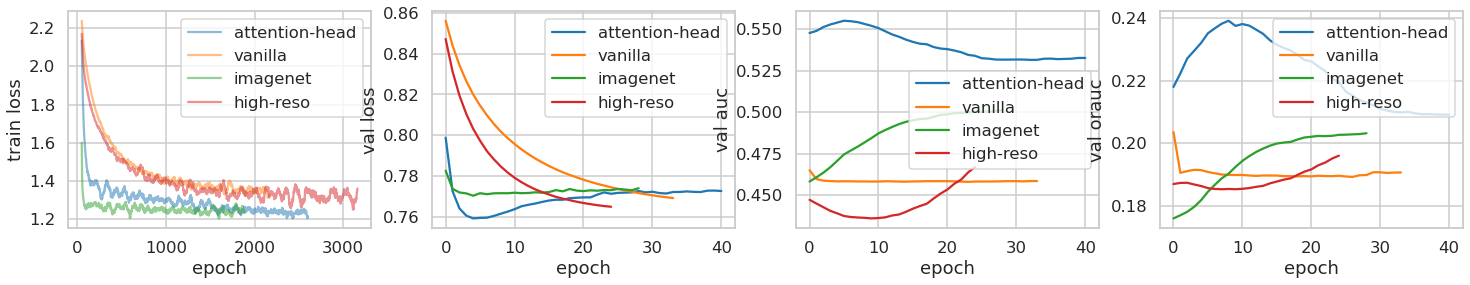

In [22]:
file_prefixes = [('ffdm', 'gmic', 'linear/', 'swav_resnet18_milatten1_batch128'),
                 ('ffdm', 'gmic', 'linear/', 'swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32'),
                 ('ffdm', 'gmic', 'linear/', 'imagenet'),
                 ('ffdm', 'gmic_highreso', 'linear/', 'swav_resnet18_avgpool_coslr-200e-ori_resolution_skynet'),
                 ]
titles = ['attention-head', 'vanilla', 'imagenet', 'high-reso']

learning_curves_comparsion(file_prefixes, titles)